# Предварительный анализ данных (EDA)

В данном notebook представлена часть проведенного предварительного анализа данных для научной исследовательской работы на тему: "Оптимизация ключевой метрики TTH для найма линейного персонала".
В данных содержится часть нанимаемых сотрудников на период 2018-2020.

### Цели:

1. Изучение синтетических и реальных данных.
2. Анализ этапов процесса найма.
3. Расчет Time To Hire для принятых кандидатов на позицию "Продавец-кассир".
4. Анализ влияния департамента на TTH кандидатов.
5. Анализ времени, на прохождение этапов.
6. Анализ дней недели, в которых начинался процесс найма и в которых заканчивался.
7. Анализ target переменной (Time to Hire) на наличие выбросов.

### Библиотеки:

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

### Функции для визуализации:

In [3]:
def countplot(data, column, candidats, info=True, X=True):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=data, x=column, palette='viridis')
    
    if info:
        for i, label in enumerate(ax.get_xticklabels()):
            text = label.get_text()
            print(f'{i} - {text}')
    
    if X:
        ax.set_xticklabels(ax.get_xticks(), rotation=90)
    
    plt.axhline(y=candidats, color='r', linestyle='--')
    
    
    for p in ax.patches:  
        percentage = '{:.1f}%'.format(100 * p.get_height()/candidats)  
        x = p.get_x() + p.get_width() / 2  
        y = p.get_height() + 0.02  
        ax.annotate(percentage, (x, y), ha='center', fontsize=10)
    
    plt.show()

Создание графиков распределения.
- data: DataFrame;
- column: столбец;
- candidats: количество кандидатов;
- info: вывод информации по оси Ox (default = True);
- X: заменить labels Ox на числа (default = True);

### Загрузка данных:

In [4]:
file_names = ['data2018.csv', 'data2019.csv', 'data2020.csv']
data = [pd.read_csv(file_name, low_memory=False) for file_name in file_names]

data = pd.concat(data, ignore_index=True)

### 1 Изучение синтетических и реальных данных

In [5]:
print('Количество кандидатов в данных:', '{0:,}'.format(data.id_applicant.nunique()).replace(',', ' '))
data.head(5)

Количество кандидатов в данных: 2 281 634


,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action
0,3080432,2883423,-1,9044,2018-10-16 18:11:10.00318+00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
1,2873477,2761171,-1,32087,2018-08-15 10:36:32.936322+00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
2,2896621,2776555,-1,32087,2018-08-22 14:09:27.083354+00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
3,2906437,2782282,-1,32087,2018-08-24 15:55:27.912704+00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
4,2965200,2816229,-1,32087,2018-09-11 15:00:49.242929+00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False


In [6]:
df = data.copy()

In [7]:
df.dtypes

id_applicant         int64
id_partner           int64
id_log               int64
department_id        int64
action_date         object
stage_name          object
activity_name       object
result_name         object
position_name       object
is_active_action    object
is_open_action      object
dtype: object

Выделим только кандидатов, кто по итогу был принят на работу на позицию "Продавец-кассир":

In [8]:
access_candidats = df[
    (df['stage_name']=='Оформление') & (df['result_name']=='Принят')
    ]['id_applicant'].values

df = df[
    df['id_applicant'].isin(access_candidats) &
    (df['position_name'] == 'Продавец-кассир') &
    (df['is_active_action'] != False)
]

In [9]:
synt = df[df['id_log'] == -1]
real = df[df['id_log'] != -1]

In [10]:
print('Количество синтетических данных:', '{0:,}'.format(synt.shape[0]).replace(',', ' '))
print('Количество реальных данных:', '{0:,}'.format(real.shape[0]).replace(',', ' '))

Количество синтетических данных: 136 316
Количество реальных данных: 1 388 807


##### Распределение этапов для уникальных кандидтов

In [11]:
count_candidats = real['id_applicant'].nunique()
df_unique_stages = real.drop_duplicates(subset=['id_applicant', 'stage_name'])

0 - Оформление
1 - Назначение времени на оформление/медосмотр
2 - СБ
3 - Интервью с руководителем
4 - Обработка
5 - Ожидание
6 - Отказался
7 - Не прошел СБ
8 - Выход на работу
9 - Резерв
10 - Смена вакансии
11 - Мы отказали
12 - Кадровый резерв


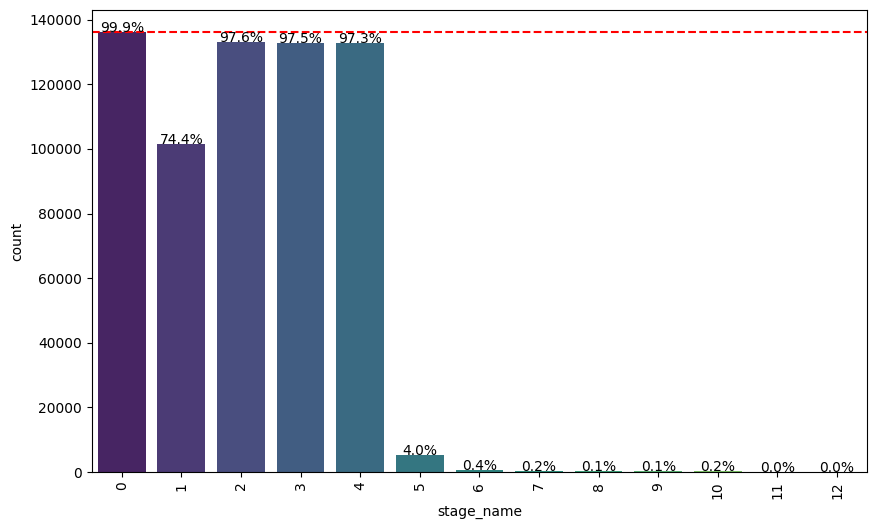

In [12]:
countplot(df_unique_stages, 'stage_name', count_candidats)

Почти все кандидаты в реальных данных имеют такие этапы, как: "Оформление", "СБ", "Интервью с руководителем" и "Обработка".

0 - Оформление
1 - Назначение времени на оформление/медосмотр
2 - СБ
3 - Интервью с руководителем
4 - Обработка
5 - Ожидание
6 - Отказался
7 - Не прошел СБ
8 - Выход на работу
9 - Резерв
10 - Смена вакансии
11 - Мы отказали
12 - Кадровый резерв


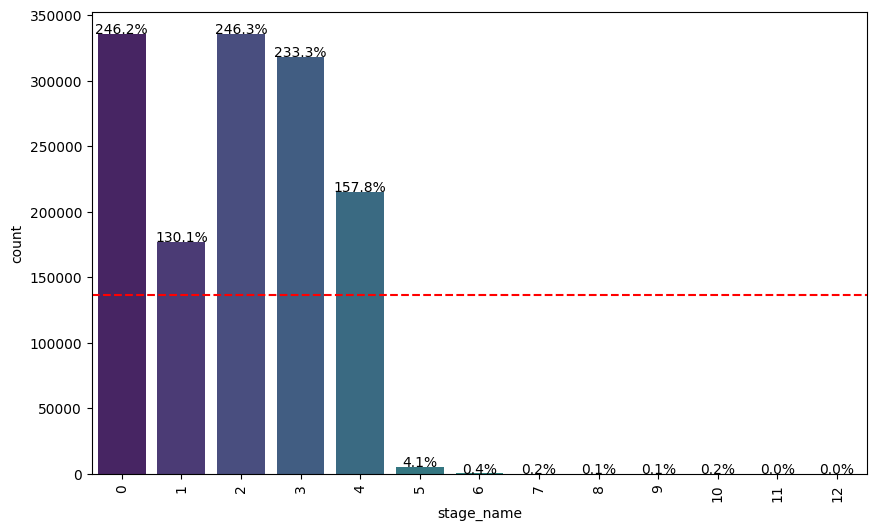

In [13]:
countplot(real, 'stage_name', count_candidats)

По данной визуализации можно сделать вывод, что у некоторых кандидатов этапы "Оформление", "Назначение времени на оформление/медосмотр", "СБ", "Интервью с руководителем" и "Обработка" появляются в процессе найма больше одного раза.

0 - Создание кандидата
1 - Оформление
2 - Назначение времени на оформление/медосмотр


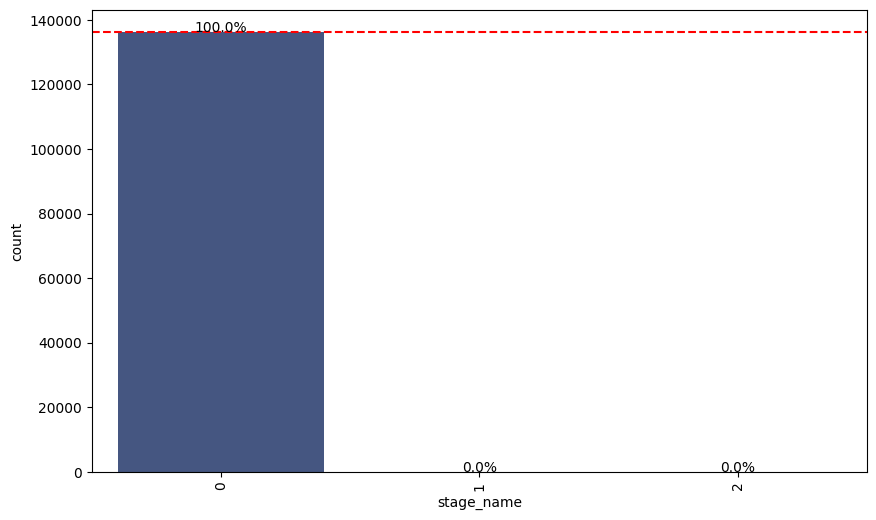

In [14]:
synt_candidats = synt['id_applicant'].nunique()
countplot(synt, 'stage_name', synt_candidats)

### 2 Анализ этапов процесса найма

Для этапа Оформление activity_name:
0 - Узнать результаты приема
1 - Назначить время на оформление/медосмотр
2 - Назначить время на оформление/медосмотр (недозвон)
3 - Узнать результаты медосмотра
4 - Назначить время на оформление
5 - Предоставить обратную связь по кандидату


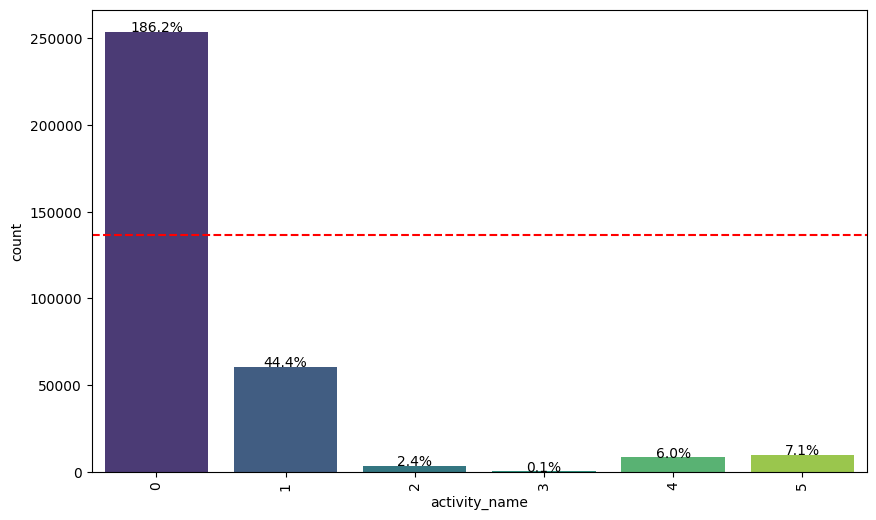

Для этапа Назначение времени на оформление/медосмотр activity_name:
0 - Назначить время на оформление/медосмотр
1 - Назначить время на оформление/медосмотр (недозвон)
2 - Узнать результаты медосмотра


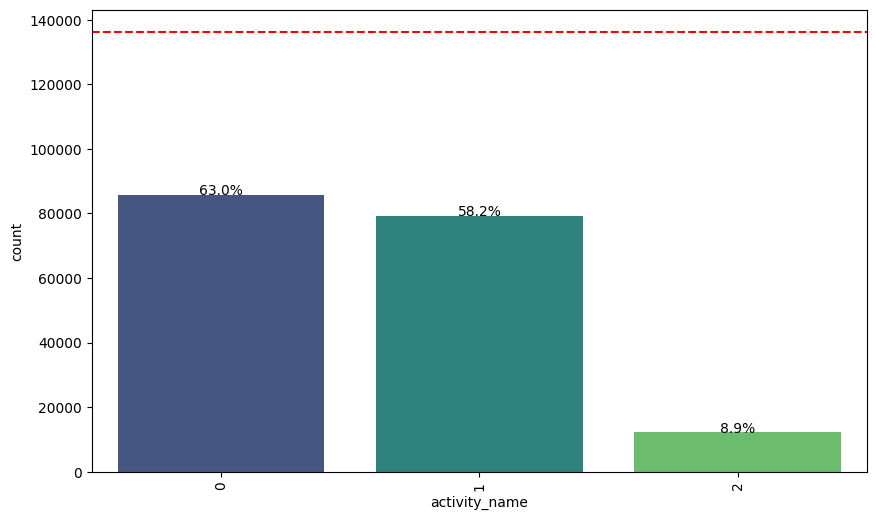

Для этапа СБ activity_name:
0 - Узнать результаты СБ
1 - Подготовить анкету кандидата
2 - Проверка формы обращения
3 - Получить согласование повторного приема и отправить в СБ


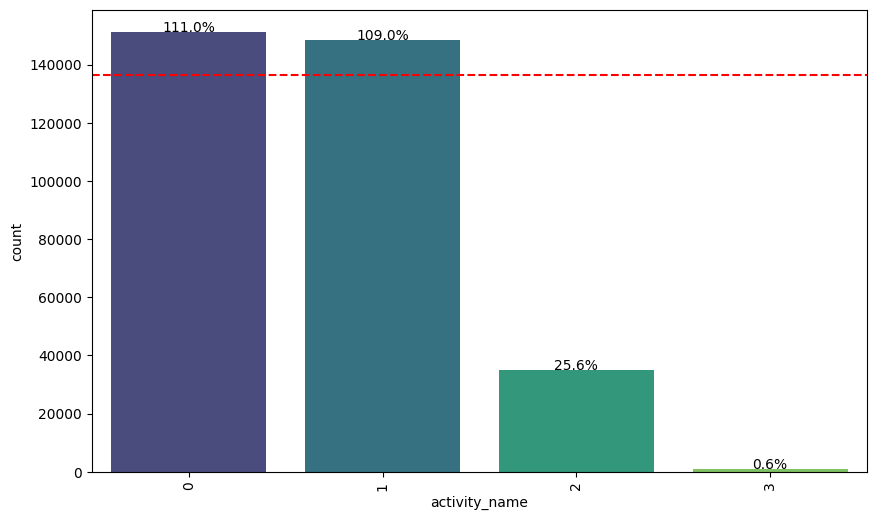

Для этапа Интервью с руководителем activity_name:
0 - Узнать результаты интервью с руководителем
1 - Назначить интервью с руководителем
2 - Предоставить обратную связь по кандидату


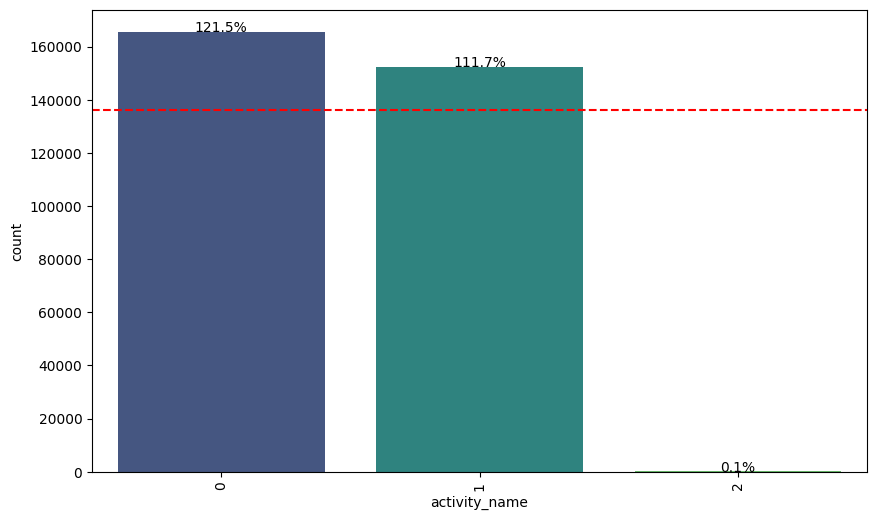

Для этапа Обработка activity_name:
0 - Провести первичную обработку
1 - Проверка формы обращения
2 - Проверка источника
3 - Назначить время на оформление/медосмотр (недозвон)


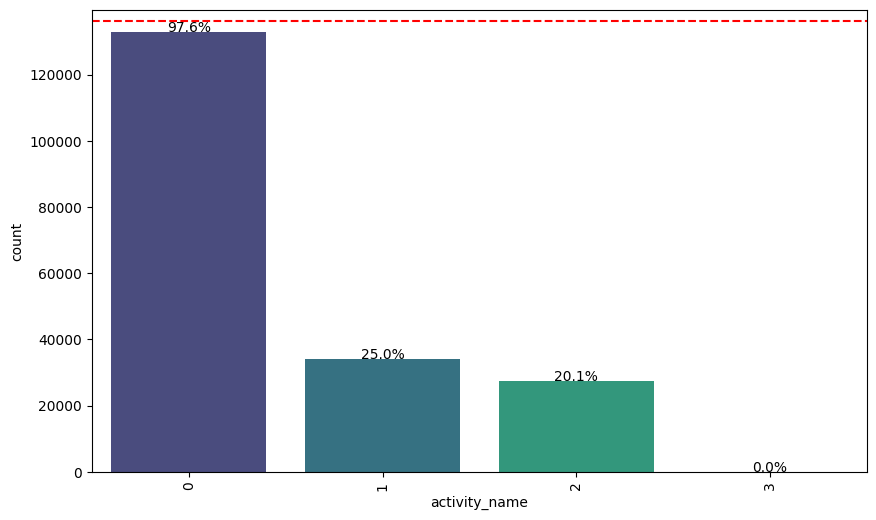

Для этапа Ожидание activity_name:
0 - Вернуть в воронку
1 - Назначить время на оформление/медосмотр
2 - Назначить интервью с руководителем
3 - Узнать результаты приема


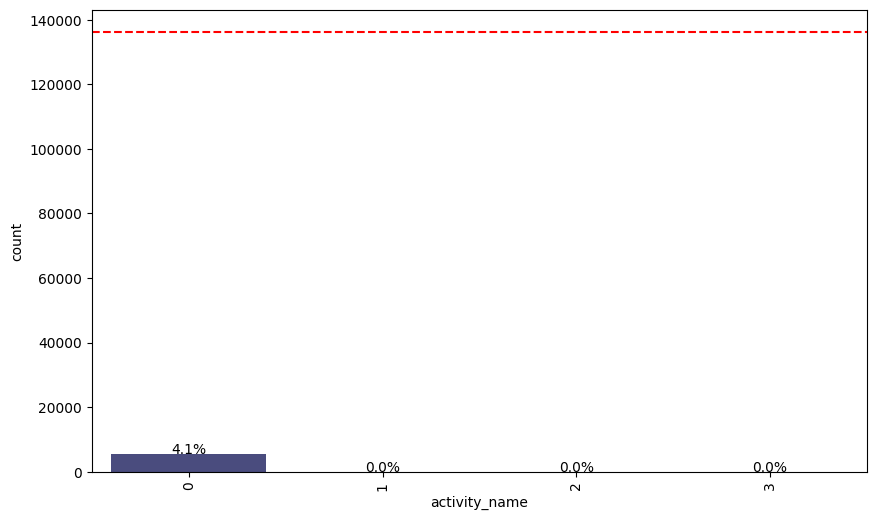

In [15]:
for col in ['Оформление', 'Назначение времени на оформление/медосмотр', 'СБ', 'Интервью с руководителем', 'Обработка', 
            'Ожидание']:
    print(f'Для этапа {col} activity_name:')
    countplot(real[real['stage_name'] == col], 'activity_name', count_candidats)
    
# Для этапа Отказался и Резерв ничего нет в activity_name


Для этапа Оформление result_name:
0 - Принят
1 - В ожидании
2 - Время назначено
3 - Недозвон
4 - Ожидание
5 - Отказ кандидата
6 - Подходит
7 - Направлен на медосмотр
8 - Оформление
9 - Не принят
10 - Резерв
11 - Встреча назначена
12 - Перенос звонка
13 - Нет обратной связи
14 - ОС предоставлена руководителем
15 - ОС не предоставлена руководителем
16 - Нет обратной связи от руководителя
17 - Перенос кандидата
18 - Отказ руководителя
19 - Перенос руководителя


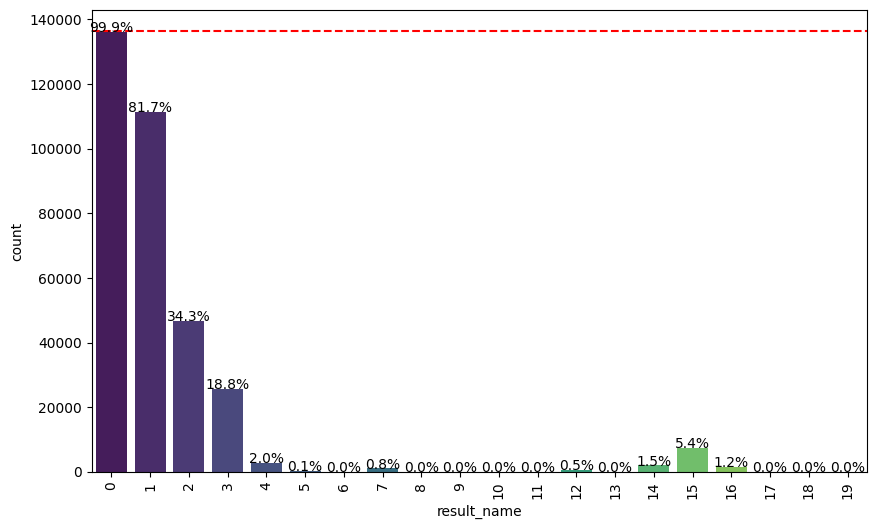

Для этапа Назначение времени на оформление/медосмотр result_name:
0 - Время назначено
1 - Недозвон
2 - Подходит
3 - Перенос звонка
4 - Отказ кандидата
5 - Ожидание
6 - Направлен на медосмотр
7 - Встреча назначена
8 - Резерв
9 - Назначить время на оформление/медосмотр
10 - СБ
11 - Нет обратной связи
12 - В ожидании
13 - Оформление


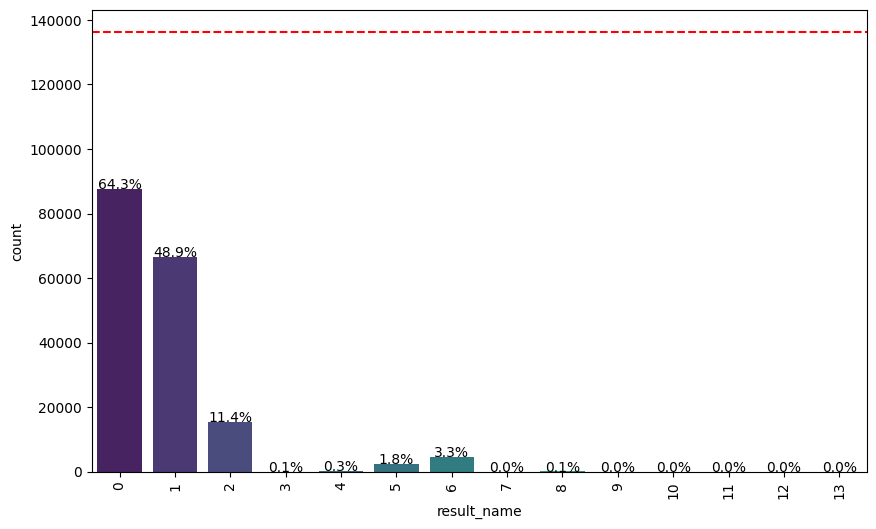

Для этапа СБ result_name:
0 - Подходит
1 - Подготовлена
2 - Нет обратной связи
3 - Не резерв
4 - Не подходит
5 - Получено
6 - Согласование повторного приема
7 - Уточнение данных
8 - Встреча назначена
9 - Не получено
10 - Кадровый резерв
11 - Перенос кандидата
12 - Недозвон
13 - Не подготовлена
14 - СБ


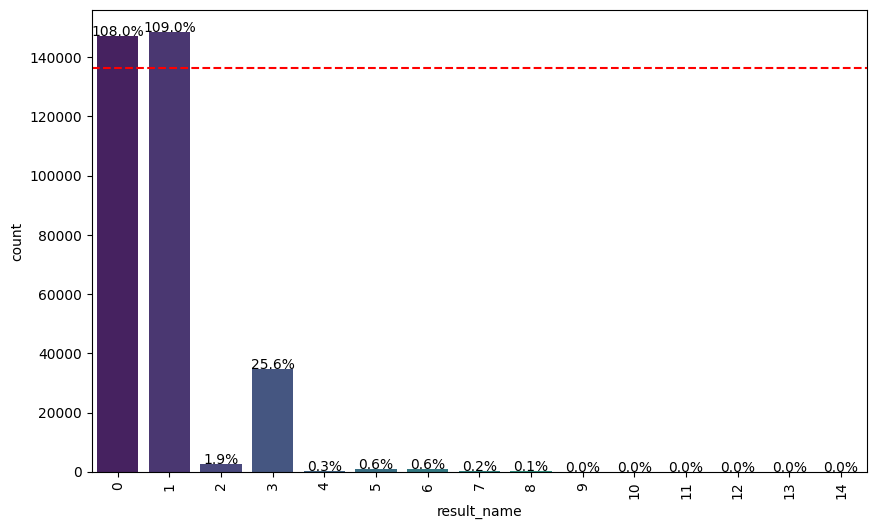

Для этапа Интервью с руководителем result_name:
0 - Подходит
1 - Встреча назначена
2 - Нет обратной связи
3 - Перенос кандидата
4 - Перенос руководителя
5 - Ожидание
6 - Отказ кандидата
7 - Резерв
8 - Перенос звонка
9 - Интервью с руководителем
10 - Не подходит
11 - Недозвон
12 - ОС предоставлена руководителем
13 - ОС не предоставлена руководителем
14 - Нет обратной связи от руководителя


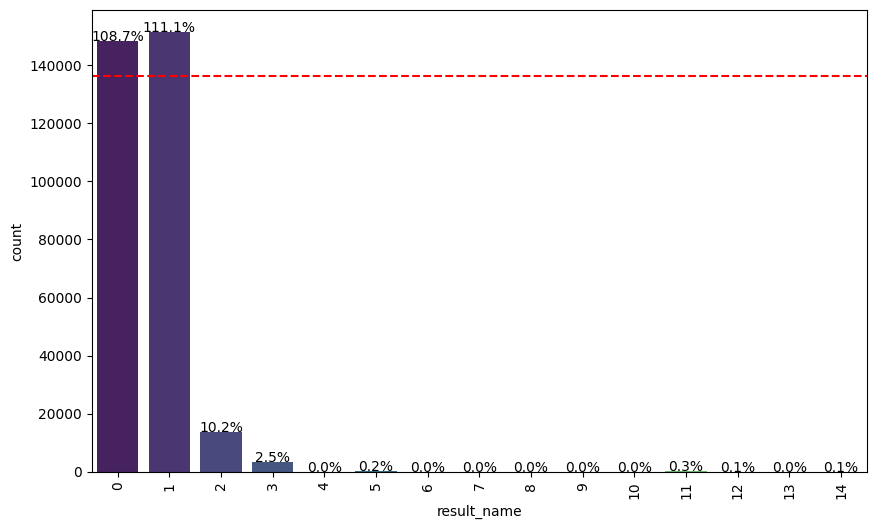

Для этапа Обработка result_name:
0 - Подходит
1 - Источник не Яндекс Цифра
2 - Не резерв
3 - Недозвон
4 - Резерв
5 - Кадровый резерв
6 - Источник Яндекс Цифра
7 - Отказ кандидата
8 - Перенос звонка
9 - Ожидание
10 - Встреча назначена
11 - Не подходит
12 - Назначить время на оформление/медосмотр
13 - Обработка
14 - Интервью с руководителем


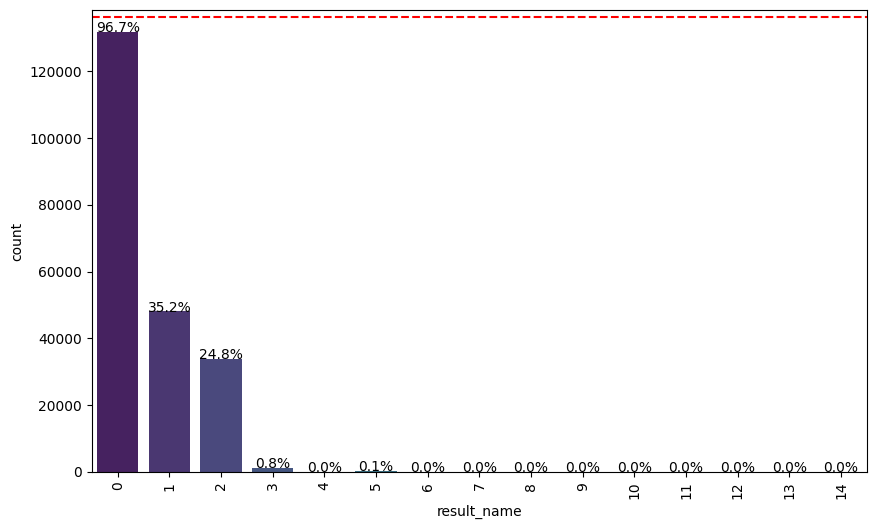

Для этапа Ожидание result_name:
0 - Оформление
1 - Назначить время на оформление/медосмотр
2 - Подходит
3 - СБ
4 - Интервью с руководителем
5 - Ожидание
6 - Обработка
7 - Недозвон
8 - В ожидании
9 - Время назначено
10 - Нет обратной связи


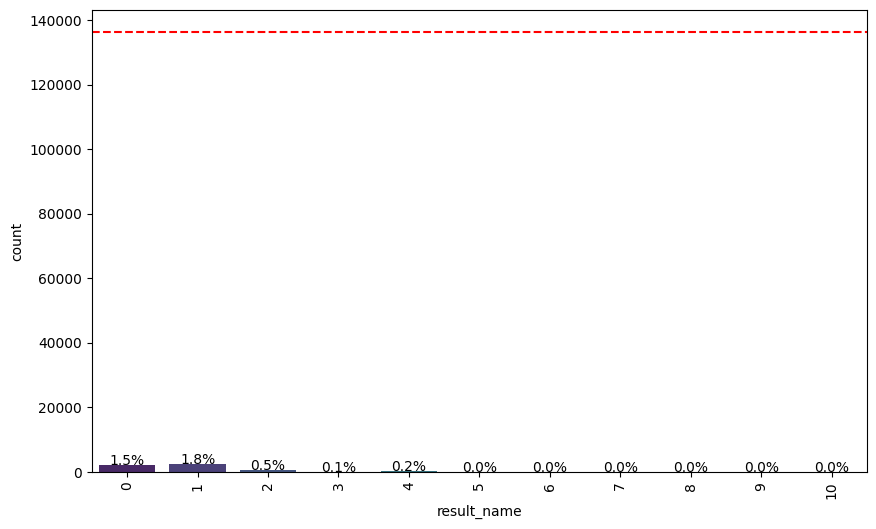

Для этапа Отказался result_name:
0 - Подходит
1 - Ожидание
2 - В ожидании
3 - Недозвон
4 - Нет обратной связи
5 - Время назначено


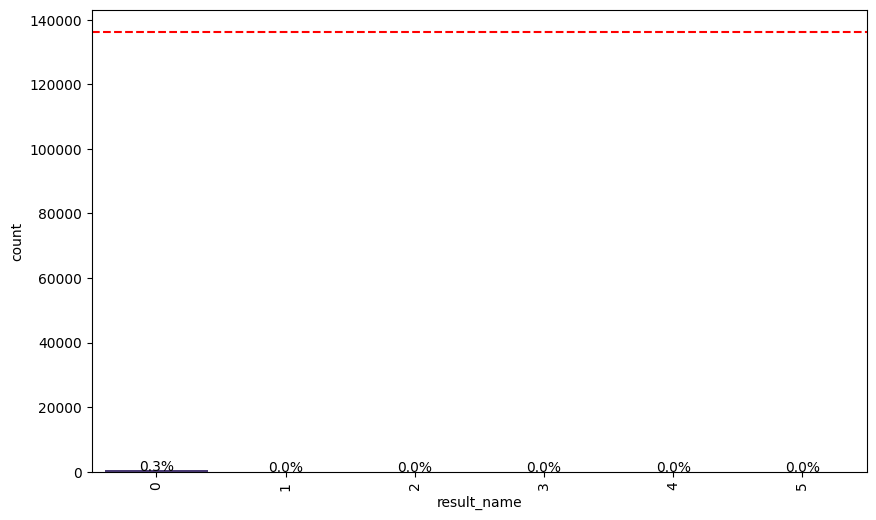

Для этапа Резерв result_name:
0 - Подходит
1 - Ожидание
2 - В ожидании


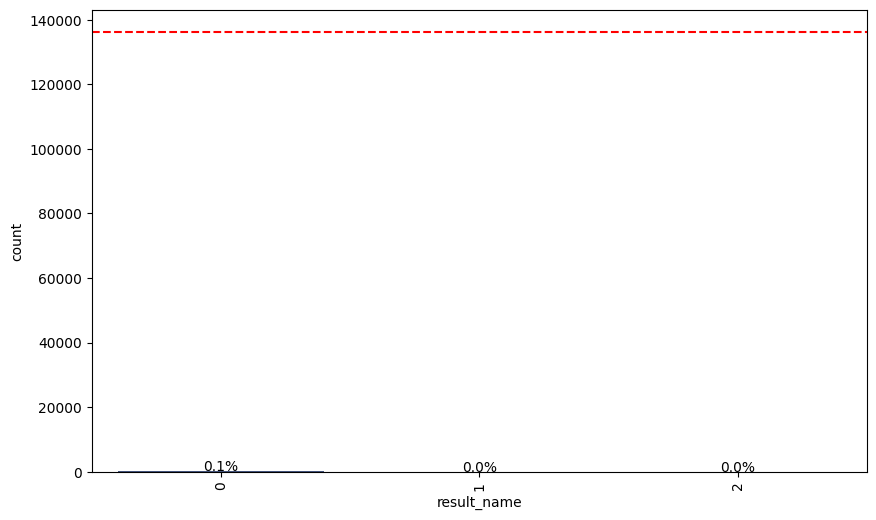

In [16]:
for col in ['Оформление', 'Назначение времени на оформление/медосмотр', 'СБ', 'Интервью с руководителем', 'Обработка', 
            'Ожидание', 'Отказался', 'Резерв']:
    print(f'Для этапа {col} result_name:')
    countplot(real[real['stage_name'] == col], 'result_name', count_candidats)

### 3 Расчет Time To Hire для принятых кандидатов на позицию "Продавец-кассир"

In [17]:
# Работа с кандидатами и расчет их TTH
min_max_dates = real.sort_values(by=['id_applicant', 'action_date']).groupby('id_applicant')['action_date'].agg(['min', 'max'])
min_max_dates['min'] = pd.to_datetime(min_max_dates['min'])
min_max_dates['max'] = pd.to_datetime(min_max_dates['max'])
min_max_dates['TTH'] = min_max_dates['max'] - min_max_dates['min']
min_max_dates['year_month'] = min_max_dates['max'].dt.strftime('%Y-%m')
min_max_dates['TTH'] = min_max_dates['TTH'].dt.total_seconds() / (24 * 3600)
min_max_dates['id_applicant'] = min_max_dates.index

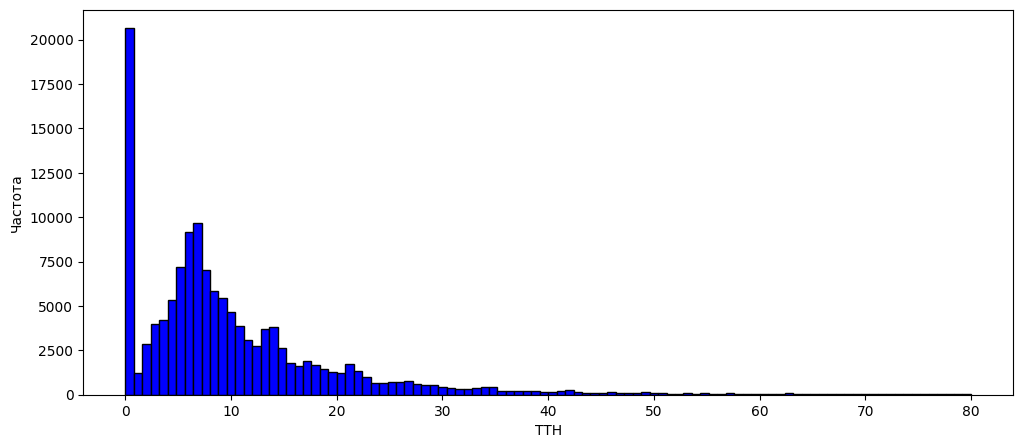

In [18]:
plt.figure(figsize=(12, 5))
plt.hist(min_max_dates['TTH'], color='blue', edgecolor='black', range=(0, 80), bins=100)

plt.xlabel('TTH')
plt.ylabel('Частота')
plt.show()

Распределение получилось двухмодальным, то есть имеет максимум в 0 и максимум около 7. Можно изучить распределение кандидатов с TTH < 1 дня, относительно количества всех кандидатов.

In [19]:
mapping_dict = dict(zip(real['id_applicant'], real['department_id']))
min_max_dates['department_id'] = min_max_dates['id_applicant'].map(mapping_dict)

min_max_dates['depart_tth'] = min_max_dates['department_id'].map(min_max_dates.groupby('department_id')['TTH'].mean())

min_max_dates['start_day'] = min_max_dates['min'].dt.day_name()
min_max_dates['end_day'] = min_max_dates['max'].dt.day_name()

meth = min_max_dates.sort_values(by='year_month')

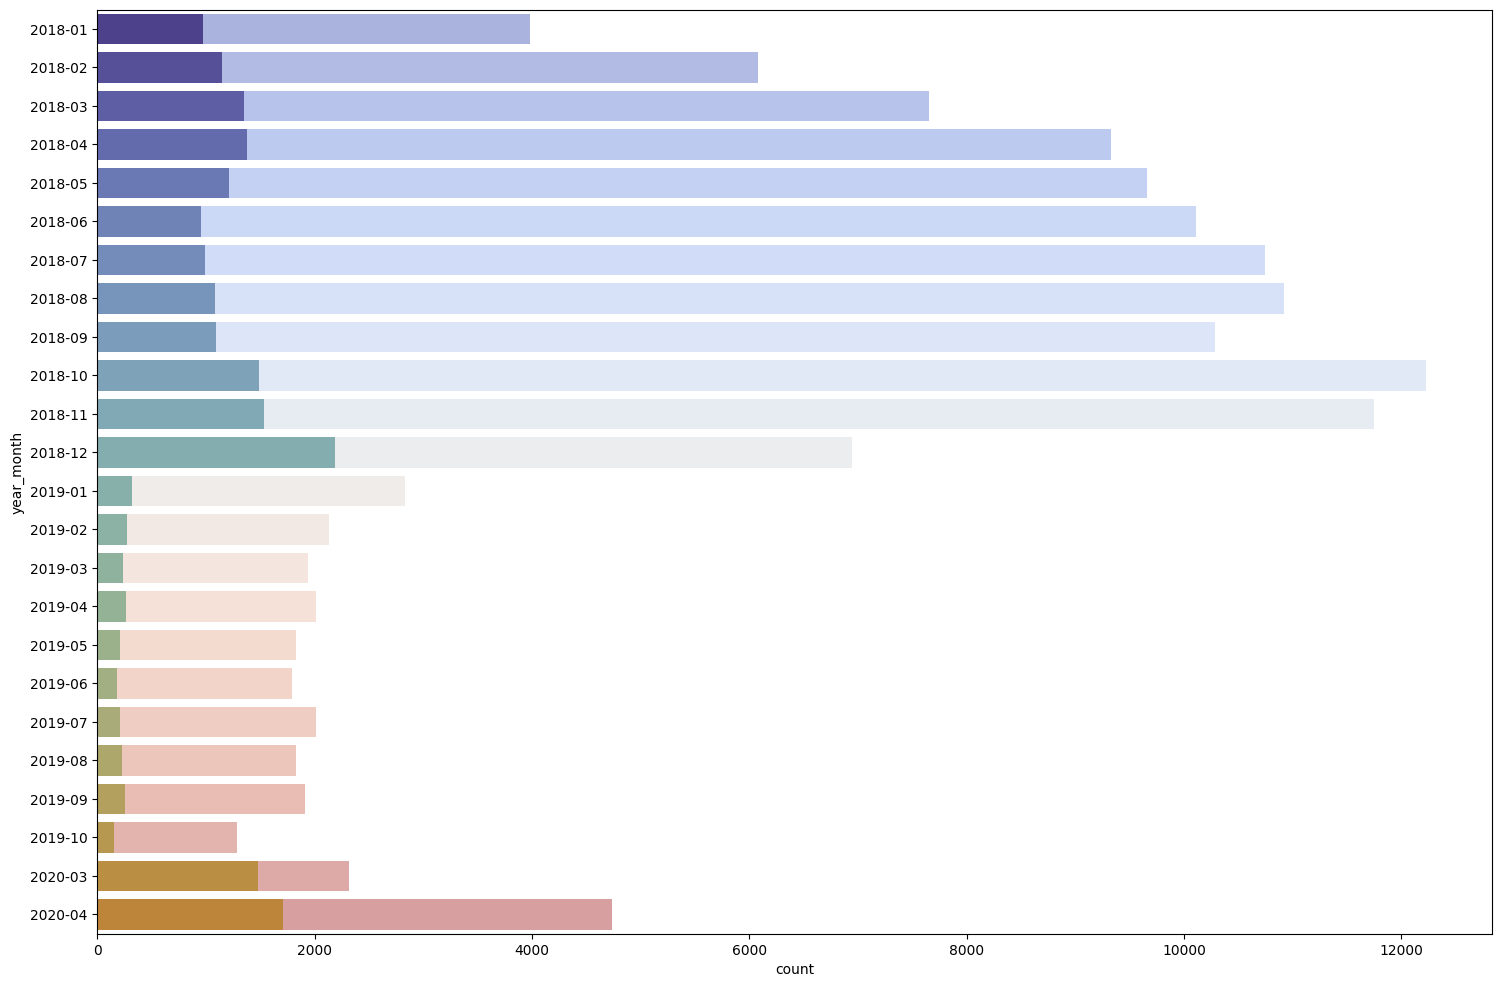

In [23]:
plt.figure(figsize=(18,12))
ax1 = plt.gca()
sns.countplot(data=meth[meth['TTH'] < 1], y='year_month', palette='viridis', ax=ax1)

sns.countplot(data=meth, y='year_month', palette='coolwarm', alpha=0.5)

plt.show()

In [26]:
print(f"Средний TTH: {min_max_dates['TTH'].mean()}\n")
print(f"Средний TTH за 2020 год: {min_max_dates[min_max_dates['year_month'].str.startswith('2020')]['TTH'].mean()}")
print(f"Средний TTH за 2019 год: {min_max_dates[min_max_dates['year_month'].str.startswith('2019')]['TTH'].mean()}")
print(f"Средний TTH за 2018 год: {min_max_dates[min_max_dates['year_month'].str.startswith('2018')]['TTH'].mean()}")

Средний TTH: 13.191348716991572

Средний TTH за 2020 год: 3.812933245842448
Средний TTH за 2019 год: 29.770934911159774
Средний TTH за 2018 год: 10.836815405097303


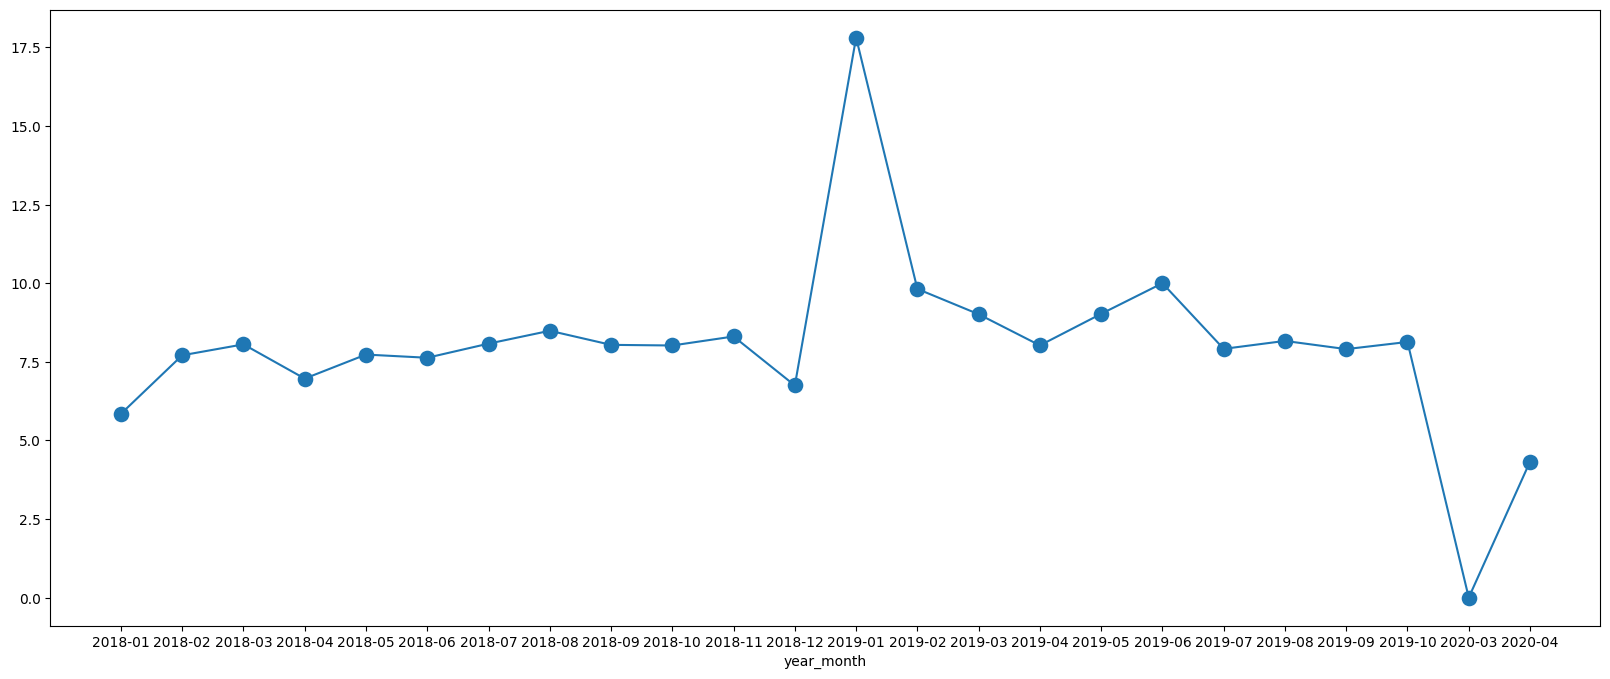

In [27]:
mean_tth_by_year_month = min_max_dates.groupby(min_max_dates['year_month'])['TTH'].median()

plt.figure(figsize=(20, 8))
sns.scatterplot(data=mean_tth_by_year_month, x=mean_tth_by_year_month.index, y=mean_tth_by_year_month.values, linewidths=0, s=150)
sns.lineplot(x=mean_tth_by_year_month.index, y=mean_tth_by_year_month.values)
plt.show()

### 4 Анализ влияния департамента на TTH кандидатов

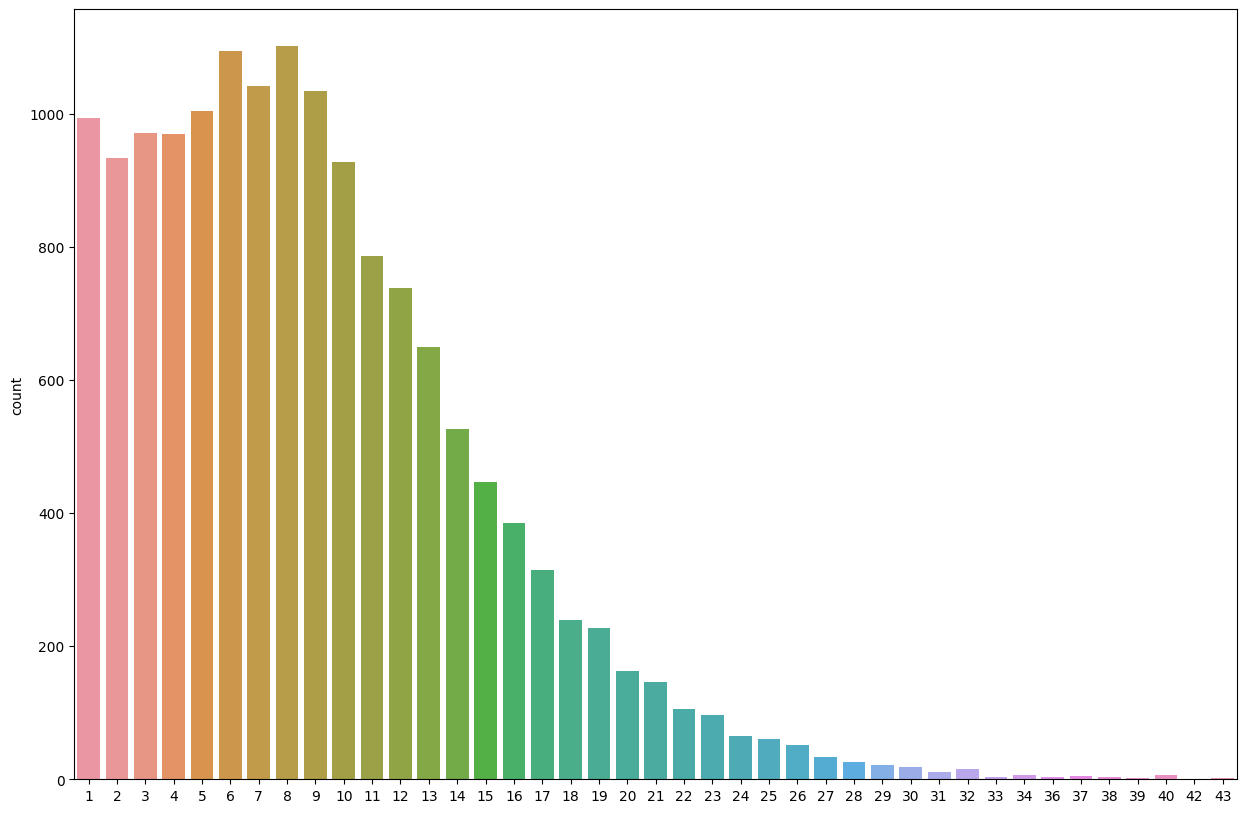

In [28]:
depart_count = real.drop_duplicates(subset='id_applicant').groupby('department_id')['id_applicant'].count()

plt.figure(figsize=(15,10))
sns.countplot(x=depart_count.values)
plt.show()

In [38]:
train = min_max_dates[['TTH', 'depart_tth', 'year_month']].copy()
train['year'] = train['year_month'].str.split('-').str[0]

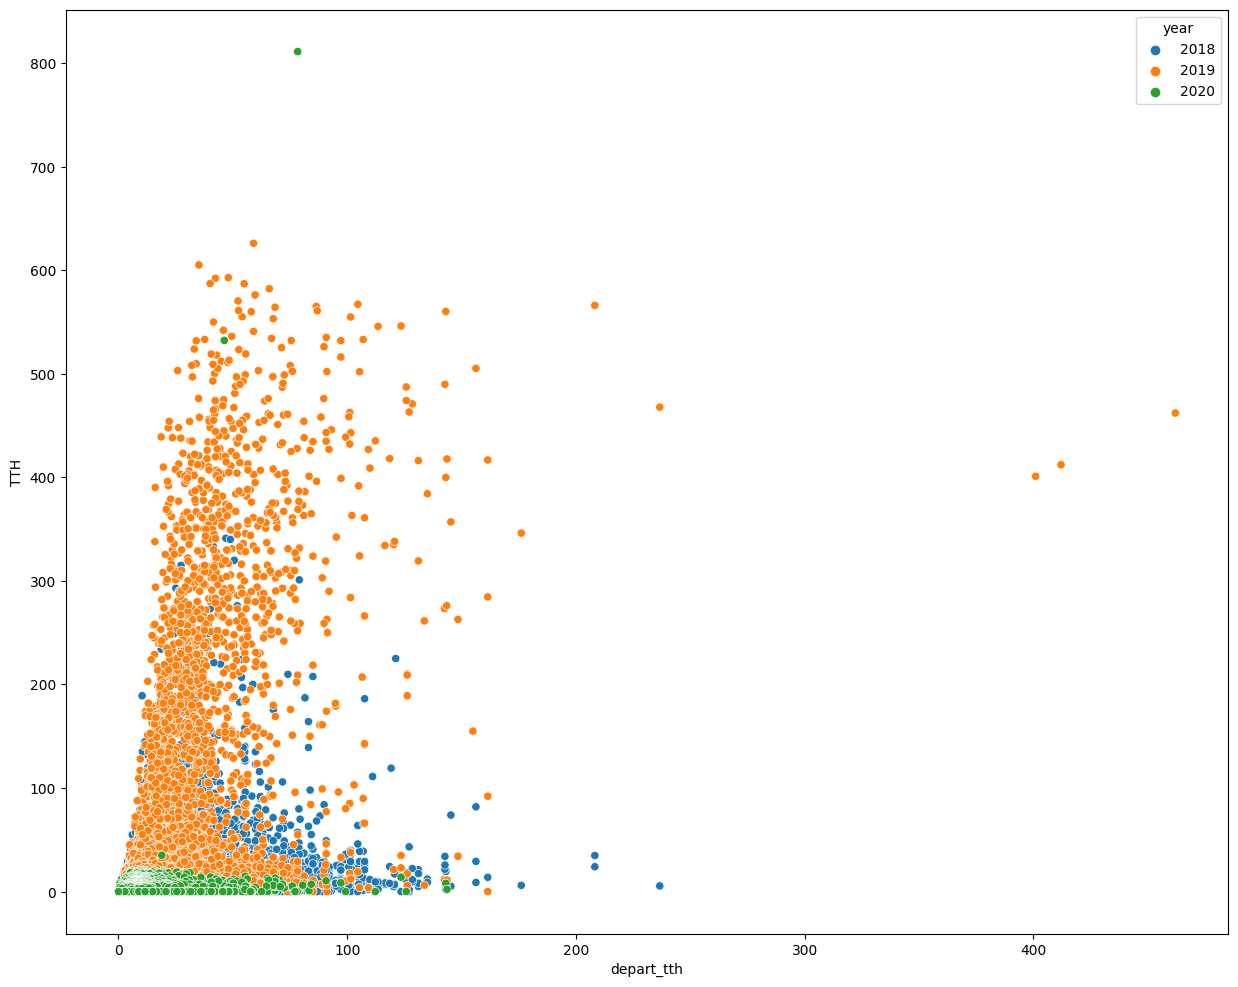

In [82]:
plt.figure(figsize=(15, 12))
sns.scatterplot(data=train, x='depart_tth', y='TTH', hue='year')
plt.show()

In [29]:
analys = min_max_dates[['id_applicant', 'TTH']]

In [30]:
stages = real['stage_name'].unique()


for stage in stages:
    stage_analys = real[real['stage_name'] == stage].sort_values(by=['id_applicant', 'action_date']).groupby('id_applicant')['action_date'].agg(['min', 'max'])
    stage_analys['min'] = pd.to_datetime(stage_analys['min'])
    stage_analys['max'] = pd.to_datetime(stage_analys['max'])
    analys[f'time_{stage}'] = stage_analys['max'] - stage_analys['min']
    print(f'time_{stage} добавлено.')

D:\Anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


time_Оформление добавлено.
time_Назначение времени на оформление/медосмотр добавлено.
time_СБ добавлено.
time_Интервью с руководителем добавлено.
time_Обработка добавлено.
time_Ожидание добавлено.
time_Отказался добавлено.
time_Не прошел СБ добавлено.
time_Выход на работу добавлено.
time_Резерв добавлено.
time_Смена вакансии добавлено.
time_Мы отказали добавлено.
time_Кадровый резерв добавлено.


In [31]:
analys.head(5)

,id_applicant,TTH,time_Оформление,time_Назначение времени на оформление/медосмотр,time_СБ,time_Интервью с руководителем,time_Обработка,time_Ожидание,time_Отказался,time_Не прошел СБ,time_Выход на работу,time_Резерв,time_Смена вакансии,time_Мы отказали,time_Кадровый резерв
id_applicant,,,,,,,,,,,,,,,
2196746,2196746,27.685659,16 days 05:38:11.497642,0 days 00:00:00,0 days 09:11:22.737155,0 days 00:00:00.505816,0 days,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2196747,2196747,6.133310,0 days 00:00:00,1 days 00:36:08.646357,4 days 06:38:39.968942,0 days 00:00:00.585901,0 days,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2196748,2196748,28.251127,0 days 00:00:00,0 days 00:00:00,4 days 10:35:02.703748,0 days 00:00:00.690977,0 days,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2196752,2196752,17.202996,10 days 00:17:09.885495,0 days 02:11:43.109234,4 days 07:35:27.461533,0 days 00:00:00.503795,0 days,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2196753,2196753,10.153854,3 days 18:34:22.108062,2 days 06:36:11.605357,0 days 08:41:51.044710,0 days 00:00:00.599852,0 days,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


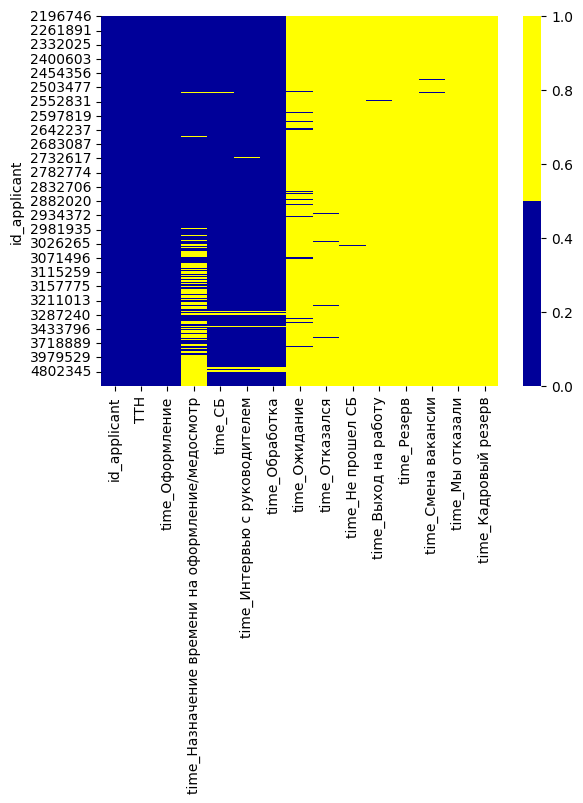

In [32]:
cols = analys.columns[:15]
# желтый - пропущены, синий - не пропущены
colours = ['#000099', '#ffff00']
sns.heatmap(analys[cols].isna(), cmap=sns.color_palette(colours))

plt.show()

### 5 Анализ времени, на прохождение этапов

In [65]:
analys = analys[
    ['id_applicant', 'TTH', 'time_Оформление', 
     'time_Назначение времени на оформление/медосмотр', 
     'time_СБ', 'time_Интервью с руководителем']]

analys['year'] = min_max_dates['year_month'].str.split('-').str[0]

In [69]:
dict_2018 = {}
dict_2019 = {}
dict_2020 = {}

years = ['2018', '2019', '2020']

for year in years:
    cols = analys[analys['year'] == year].drop(['id_applicant', 'TTH', 'year'], axis=1).columns
    
    for col in cols:
        pct_missing = np.mean(analys[analys['year'] == year][col].isna()) * 100
        if year == '2018':
            dict_2018[col] = pct_missing
        elif year == '2019':
            dict_2019[col] = pct_missing
        elif year == '2020':
            dict_2020[col] = pct_missing

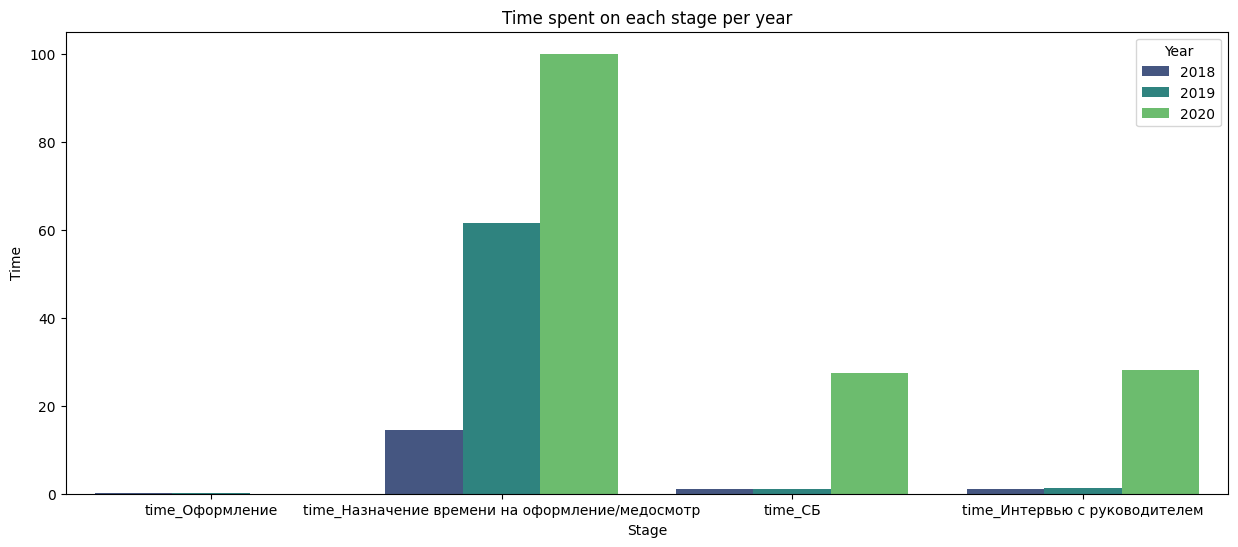

In [72]:
df_2018 = pd.DataFrame(list(dict_2018.items()), columns=['Stage', 'Time'])
df_2019 = pd.DataFrame(list(dict_2019.items()), columns=['Stage', 'Time'])
df_2020 = pd.DataFrame(list(dict_2020.items()), columns=['Stage', 'Time'])

df_2018['Year'] = '2018'
df_2019['Year'] = '2019'
df_2020['Year'] = '2020'

df = pd.concat([df_2018, df_2019, df_2020])

plt.figure(figsize=(15,6))
sns.barplot(data=df, x='Stage', y='Time', hue='Year', palette='viridis')
plt.title('Потраченное время на популярные этапы за года')
plt.show()

### 6 Анализ дней недели, в которых начинался процесс найма и в которых заканчивался

In [33]:
weekday_names = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}


##### Начало найма кандидатов

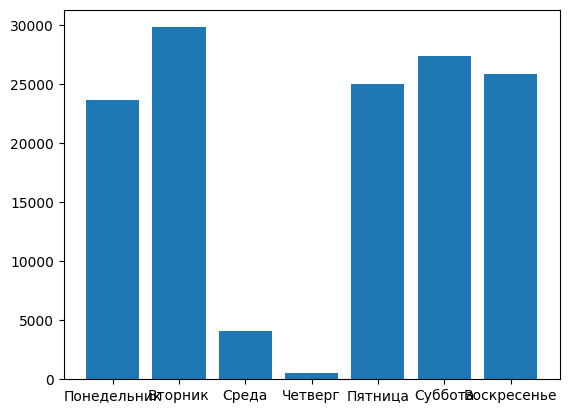

In [36]:
weekday_counts = min_max_dates['start_day'].value_counts().sort_index()
plt.bar(weekday_names.values(), weekday_counts)
plt.show()

##### Конец найма кандидатов

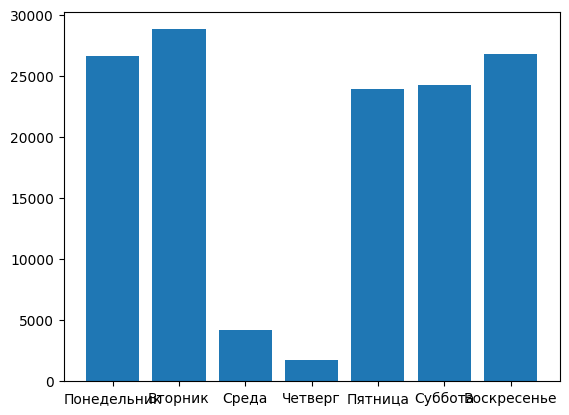

In [35]:
weekday_counts = min_max_dates['end_day'].value_counts().sort_index()
plt.bar(weekday_names.values(), weekday_counts)
plt.show()

In [84]:
train['month_of_year'] = train['year_month'].astype('datetime64').dt.month
train['season'] = (train['month_of_year'] / 4).astype('int')

### 7 Анализ target переменной (Time to Hire) на наличие выбросов

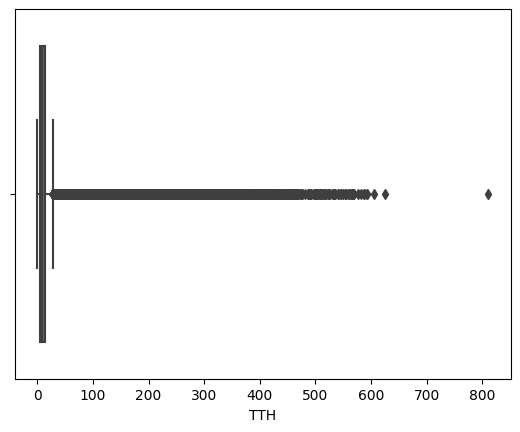

In [39]:
sns.boxplot(data = train, x='TTH')
plt.show()

Прологарифмируем TTH и построим boxplot:

D:\Anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


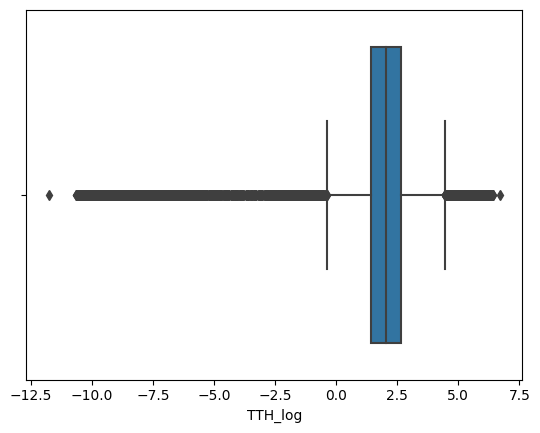

In [41]:
tth_a = train[train['TTH'] != 0]

tth_a['TTH_log'] = tth_a['TTH'].apply(np.log)

sns.boxplot(data = tth_a, x='TTH_log')
plt.show()

In [42]:
tth_a.describe()

,TTH,depart_tth,TTH_log
count,135457.000000,135457.000000,135457.000000
mean,13.274223,13.206926,0.707552
std,30.001833,10.881208,3.915739
min,0.000008,0.000026,-11.773889
25%,4.174173,7.629460,1.428916
50%,7.758009,10.267079,2.048726
75%,14.008735,14.663010,2.639681
max,811.158987,462.117984,6.698464
